In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> __________________________ </h1>
<h2> Functions </h2>



In [39]:
def read_s2_table():
    
    path = '/home/investigator/mariandbt/python/data'
    path = path + '/20231025_NEXT100_full_mapping'

    filename = os.path.join(path, "s2_table.h5")


    import h5py

    # Load the 3D dictionary from the HDF5 file
    loaded_data_dict = {}

    columns = {0:'bin_initial_x',
               1:'bin_final_x',
               2:'bin_initial_y',
               3:'bin_final_y',
               4:'s2'
              }

    with h5py.File(filename, 'r') as file:
        for table_id in file.keys():
            # Get the column names from the HDF5 attributes
            loaded_data_dict[table_id] = pd.DataFrame(file[table_id][:])
            loaded_data_dict[table_id].rename(columns = columns, inplace=True)



    s2_table = loaded_data_dict.copy()
    
    return s2_table

In [2]:
def sens_map(selected_id):
    
    # we select the response of the sensors at the end of the fibers
    pp = '/home/investigator/mariandbt/python/data'
    pp = pp + '/20231025_NEXT100_full_mapping'

    flnm = os.path.join(pp, "Next100_full_mapp_s2_inicioEL_100Kev.next.h5")
    sens = pd.read_hdf(flnm, "/MC/sns_positions")
    dst_particle = pd.read_hdf(flnm, "/MC/particles")

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(11,11), constrained_layout=True)
    
    ax.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')


    fiber_sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers

    sens_fibers = sens.loc[sens.sensor_id.isin(fiber_sens_mask)] # get the positions of said sensors

    font_size = 11
    ax.plot(sens_fibers.x, sens_fibers.y, 'o', markersize = 2*font_size)
    
    labels_fontsize = 2*font_size
    
    ax.set_xlabel('X-coordinate [mm]', fontsize = labels_fontsize)
    ax.set_ylabel('Y-coordinate [mm]', fontsize = labels_fontsize)
    ax.tick_params(axis='both', labelsize = labels_fontsize*2/3)

    for sens_id in sens_fibers.sensor_id:
        xx = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].x)
        yy = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].y)

        ax.annotate(f'{sens_id:.0f}', (xx, yy),
                    color='black', ha='center', va='center', fontsize = font_size)

    if selected_id in sens_fibers.sensor_id.values:
#         ax.plot(sens_fibers.loc[sens_fibers.sensor_id == selected_id].x, 
#                 sens_fibers.loc[sens_fibers.sensor_id == selected_id].y, 'om', 
#                 markersize = 2*font_size, label = 'Selected sensor')

        ax.legend(fontsize = labels_fontsize, loc = (.4, .6))

    else:
        ax.annotate('Not (valid) sensor ID selected', (0, 100),
                    color='black', ha='center', va='center', fontsize = font_size)
        

In [90]:
def find_rot(alpha):
    rot = -10

    while not ((alpha < (dtheta/2 + dtheta*rot)) & 
               (alpha > (-dtheta/2 + dtheta*rot))):
        rot += 1
        if rot > n_panels:
            print('ERROR')
            break

    return rot

# Vectorize the function
vect_find_rot = np.vectorize(find_rot)

In [91]:
def find_sensor(sensor_id, rot):
    
    theta = theta_dict[sensor_id]
    pos = theta_to_pos_dict[theta]

    new_pos = pos - rot*dpos
    
    if (new_pos == n_sensors/2):
        new_pos = -n_sensors/2
        
    if (new_pos > n_sensors/2):
        new_pos = new_pos%(n_sensors/2)
        
    if (new_pos < -n_sensors/2):
        new_pos = new_pos%(-n_sensors/2)
        
    new_theta = pos_to_theta_dict[new_pos]
    
    new_sens_id = sens_dict[new_theta]

    return new_sens_id


In [92]:
def find_s2(sens_id, part_id):
#     print(part_id)

    
    rr, alpha = rr_dict[part_id], alpha_dict[part_id]
    rot = rot_dict[part_id]
    new_xx, new_yy = new_xx_dict[part_id], new_yy_dict[part_id]

    new_sens_id = find_sensor(sens_id, rot) 
    s2_tab_matrix = s2_tab_dict[f'sens_{new_sens_id}']


    x_bin = int((new_xx - x_min)//x_bin_width)
    y_bin = int((new_yy - y_min)//y_bin_width)

    if ((new_xx > x_max) or 
        (new_yy > y_max) or
        (np.sqrt(new_xx**2 + new_yy**2) > fiducial_radio)
       ):
        s2_signal = 0.
    else:
        s2_signal = s2_tab_matrix[x_bin][y_bin]

#     if ((new_xx < x_max) & (new_yy < y_max)):
#         s2_signal = s2_tab_matrix[x_bin][y_bin]
#     else:
#         s2_signal = 0.

    return s2_signal

# Vectorize the function
vect_find_s2 = np.vectorize(find_s2)

In [93]:
def build_particle_dict(bb_ie):
    # particles
    tt_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_t']))
    xx_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_x']))
    yy_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_y']))
    rr_dict = dict(zip(bb_ie['particle_id'], np.sqrt(bb_ie['final_x']**2 + bb_ie['final_y']**2)))
    alpha_dict = dict(zip(bb_ie['particle_id'], np.arctan2(bb_ie['final_y'], bb_ie['final_x'])))


    rr = np.array(list(rr_dict.values()))
    alpha = np.array(list(alpha_dict.values()))
    rotation = vect_find_rot(alpha)

    new_alpha = alpha - rotation * dtheta
    new_xx = rr * np.cos(new_alpha)
    new_yy = rr * np.sin(new_alpha)


    rot_dict = dict(zip(bb_ie['particle_id'], rotation))
    new_xx_dict = dict(zip(bb_ie['particle_id'], new_xx))
    new_yy_dict = dict(zip(bb_ie['particle_id'], new_yy))

    return tt_dict, xx_dict, yy_dict, rr_dict, alpha_dict, rot_dict, new_xx_dict, new_yy_dict

In [94]:
def find_bb_ie(bb_filename, start, event_id):
    
        stop = start + chunksize

        bb_particles = pd.read_hdf(bb_filename, "/MC/particles", 
                                   start = start, stop = stop, 
                                   low_memory=True)

        bb_ie = bb_particles.query(f'(event_id == {event_id}) & (particle_name == "ie-")')
        prim_e = bb_particles.query(f'(event_id == {event_id}) & (primary == 1)')
        
        new_start = start + bb_particles.query(f'(event_id == {event_id})').index.max() - 1 
        
        return new_start, bb_ie, prim_e

<h1> __________________________ </h1>
<h2> Global parameters </h2>

In [3]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe

n_sensors = 90 

t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Files </h2>

In [4]:
path = '/home/investigator/mariandbt/python/data/'
path = path + '/20231025_NEXT100_full_mapping/next100_fibers'

filename = os.path.join(path, "20240122_Next100_bb_1.next.h5") # 1 full bb w s2

In [5]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data//20231025_NEXT100_full_mapping/next100_fibers/20240122_Next100_bb_1.next.h5 (File) ''
Last modif.: '2024-01-24T09:19:06+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(47,)) ''
/MC/hits (Table(786,)) ''
/MC/particles (Table(101386,)) ''
/MC/sns_positions (Table(3431,)) ''
/MC/sns_response (Table(2615102,)) ''



In [6]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
data = pd.read_hdf(filename, "/MC/sns_response")
particles = pd.read_hdf(filename, "/MC/particles")


In [7]:
dst = data.copy()
dst_particle = particles.copy()


In [8]:
sens_mask = pd.read_hdf(filename, "/MC/sns_positions", where='sensor_name == F_SENSOR')['sensor_id']


/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/io/pytables.py:3523: IncompatibilityWarning: 
where criteria is being ignored as this version [0.0.0] is too old (or
not-defined), read the file in and write it out to a new file to upgrade (with
the copy_to method)

  warnings.warn(ws, IncompatibilityWarning)


In [17]:
sens_mask[0]

251

In [9]:
dst_fibers = dst.loc[dst.sensor_id.isin(sens_mask)] # dst only for the sensor on the fibers
dst_fibers.time_bin = dst_fibers.time_bin*t_binning # change units to ns


/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [34]:
sens = sens_mask[23]
# sens = 204
dst_onesens = dst_fibers.loc[dst_fibers.sensor_id == sens]

In [35]:
dst_onesens

,event_id,sensor_id,time_bin,charge
782783,0,240,34.7,1
782784,0,240,70.8,1
782785,0,240,74.5,1
782786,0,240,74.8,1
782787,0,240,87.3,1
...,...,...,...,...
801349,0,240,687722.0,1
801350,0,240,688551.6,1
801351,0,240,688565.3,1
801352,0,240,688868.9,1


<h1> __________________________ </h1>
<h2> Analysis </h2>

-  <p style="font-size: 17px; color: black;"> <b> Direct s2 waveform </b> </p>

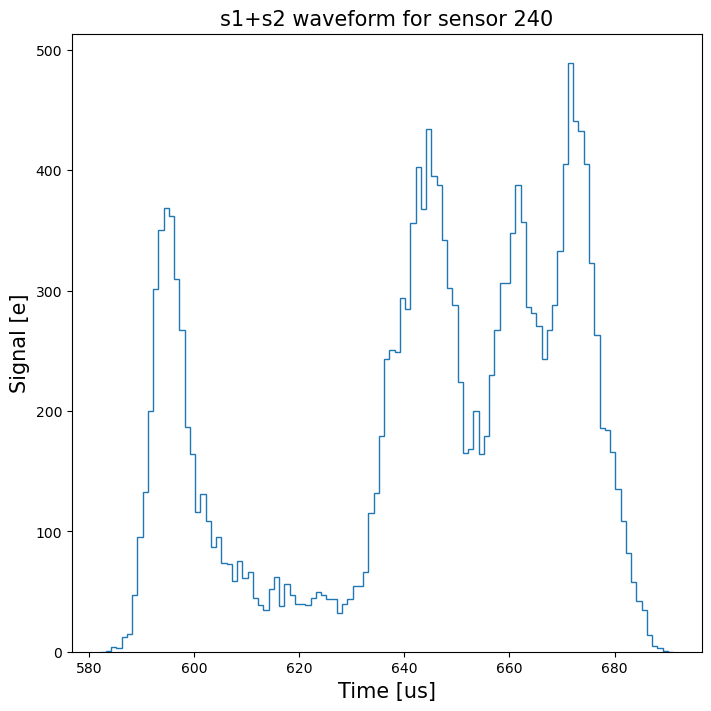

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)

font_size = 15

# signal = dst_fibers
signal = dst_onesens

tt = signal.time_bin*1e-3 # [us]
s2 = signal.charge # [e]

t_window_min = 400 # [us]
t_window_max = 1000 # [us]

t_window = (t_window_min < tt) & (tt < t_window_max)

t = tt[t_window]
s2 = s2[t_window]


bin_width = 1 # time units ([us])

binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

events, bins, bars = ax.hist(t, binin, 
                             weights = s2,
                             density=False,
                             histtype='step')

ax.set_title(f's1+s2 waveform for sensor {sens}', fontsize = font_size);
ax.set_xlabel('Time [us]', fontsize = font_size);
ax.set_ylabel('Signal [e]', fontsize = font_size);

ax.tick_params(axis='both', labelsize = font_size*2/3)

-  <p style="font-size: 17px; color: black;"> <b> Using s2 table </b> </p>

In [40]:
s2_table = read_s2_table()